# Assignment 3: Graph Visualization

## Overview
This notebook loads and analyzes a real,world social network graph using Python and NetworkX. The dataset is a subset of the Facebook Social Network from the [Stanford SNAP dataset](https://snap.stanford.edu/data/ego,Facebook.html), specifically the first 150 nodes and their connections (150 nodes, 603 edges). The goal here is to compute the graph's diameter along with additional network metrics, then visualize the structure in a way that makes the underlying patterns easy to interpret.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gzip
import os
import urllib.request

## Part 1: Load Graph Database

The full Facebook SNAP dataset is massive, so per the assignment instructions we're pulling just the first 150 nodes and their edges. This keeps things manageable while still giving us a real social network to work with.

In [2]:
# Download dataset if not present
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
filename = "facebook_combined.txt.gz"

if not os.path.exists(filename):
    print(f"Downloading dataset from {url}...")
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded to {filename}")
else:
    print(f"Dataset already exists: {filename}")

# Load subset of first 150 nodes
sample_nodes = set(range(150))
G = nx.Graph()
edges = []

with gzip.open(filename, 'rt') as f:
    for line in f:
        if line.startswith('#'):
            continue
        parts = line.strip().split()
        if len(parts) >= 2:
            node1, node2 = int(parts[0]), int(parts[1])
            if node1 in sample_nodes and node2 in sample_nodes:
                edges.append((node1, node2))

G.add_edges_from(edges)

# Remove isolated nodes
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Dataset already exists: facebook_combined.txt.gz
Graph loaded: 150 nodes, 603 edges


## Part 2: Graph Analysis

### Required Metric: Diameter
The diameter tells us the longest shortest path between any two nodes in the network, essentially the worst,case number of hops to get from one person to another.

### Additional Metrics
Beyond diameter, we're computing clustering coefficient, betweenness centrality, degree statistics, and average path length. These give us a much fuller picture of how this network is actually structured.

In [3]:
# Connectivity check
print(f"Is connected: {nx.is_connected(G)}")
print(f"Connected components: {nx.number_connected_components(G)}")

# Use largest component if disconnected
if nx.is_connected(G):
    analysis_graph = G
else:
    largest_cc = max(nx.connected_components(G), key=len)
    analysis_graph = G.subgraph(largest_cc).copy()
    print(f"Largest component size: {len(largest_cc)}")

# Diameter (required)
diameter = nx.diameter(analysis_graph)
print(f"\nDiameter: {diameter}")

# Additional path metrics
avg_path = nx.average_shortest_path_length(analysis_graph)
radius = nx.radius(analysis_graph)
print(f"Radius: {radius}")
print(f"Average shortest path length: {avg_path:.4f}")

# Density
density = nx.density(G)
print(f"Density: {density:.4f}")

# Degree statistics
degrees = [d for n, d in G.degree()]
print(f"\nAverage degree: {np.mean(degrees):.2f}")
print(f"Max degree: {max(degrees)}")
print(f"Min degree: {min(degrees)}")

# Clustering coefficient (additional metric)
avg_clustering = nx.average_clustering(G)
transitivity = nx.transitivity(G)
print(f"\nAverage clustering coefficient: {avg_clustering:.4f}")
print(f"Transitivity (global clustering): {transitivity:.4f}")

# Betweenness centrality
betweenness = nx.betweenness_centrality(G)
most_central = max(betweenness, key=betweenness.get)
print(f"\nMost central node (betweenness): {most_central}")
print(f"Max betweenness centrality: {max(betweenness.values()):.4f}")
print(f"Average betweenness centrality: {np.mean(list(betweenness.values())):.4f}")

Is connected: True
Connected components: 1

Diameter: 2
Radius: 1
Average shortest path length: 1.9460
Density: 0.0540

Average degree: 8.04
Max degree: 149
Min degree: 1

Average clustering coefficient: 0.6400
Transitivity (global clustering): 0.2090

Most central node (betweenness): 0
Max betweenness centrality: 0.8725
Average betweenness centrality: 0.0064


### Key Findings

A few things jump out here. First, the diameter of 2 combined with an average path length of ~1.95 tells us this is a textbook small,world network. Any two people in this subset are connected by at most 2 hops, which is remarkably tight.

Second, Node 0 is clearly the dominant hub. It's connected to all 149 other nodes and has the highest betweenness centrality at 0.87, meaning the vast majority of shortest paths run through it. This makes sense given the ego,network structure of the SNAP Facebook data, Node 0 is likely the central user whose friend list generated this subgraph.

Third, the average clustering coefficient of 0.64 is high, which tells us that friends of friends tend to also be friends. This is exactly what you'd expect in a social network where people form tightly knit communities.

## Part 3: Visualization

Four visualizations below. The main graph plot sizes nodes by degree and colors them by betweenness centrality, so you can immediately see which nodes are both well,connected and structurally important. The three distribution plots give us a clearer picture of how degree, clustering, and centrality are spread across the network.

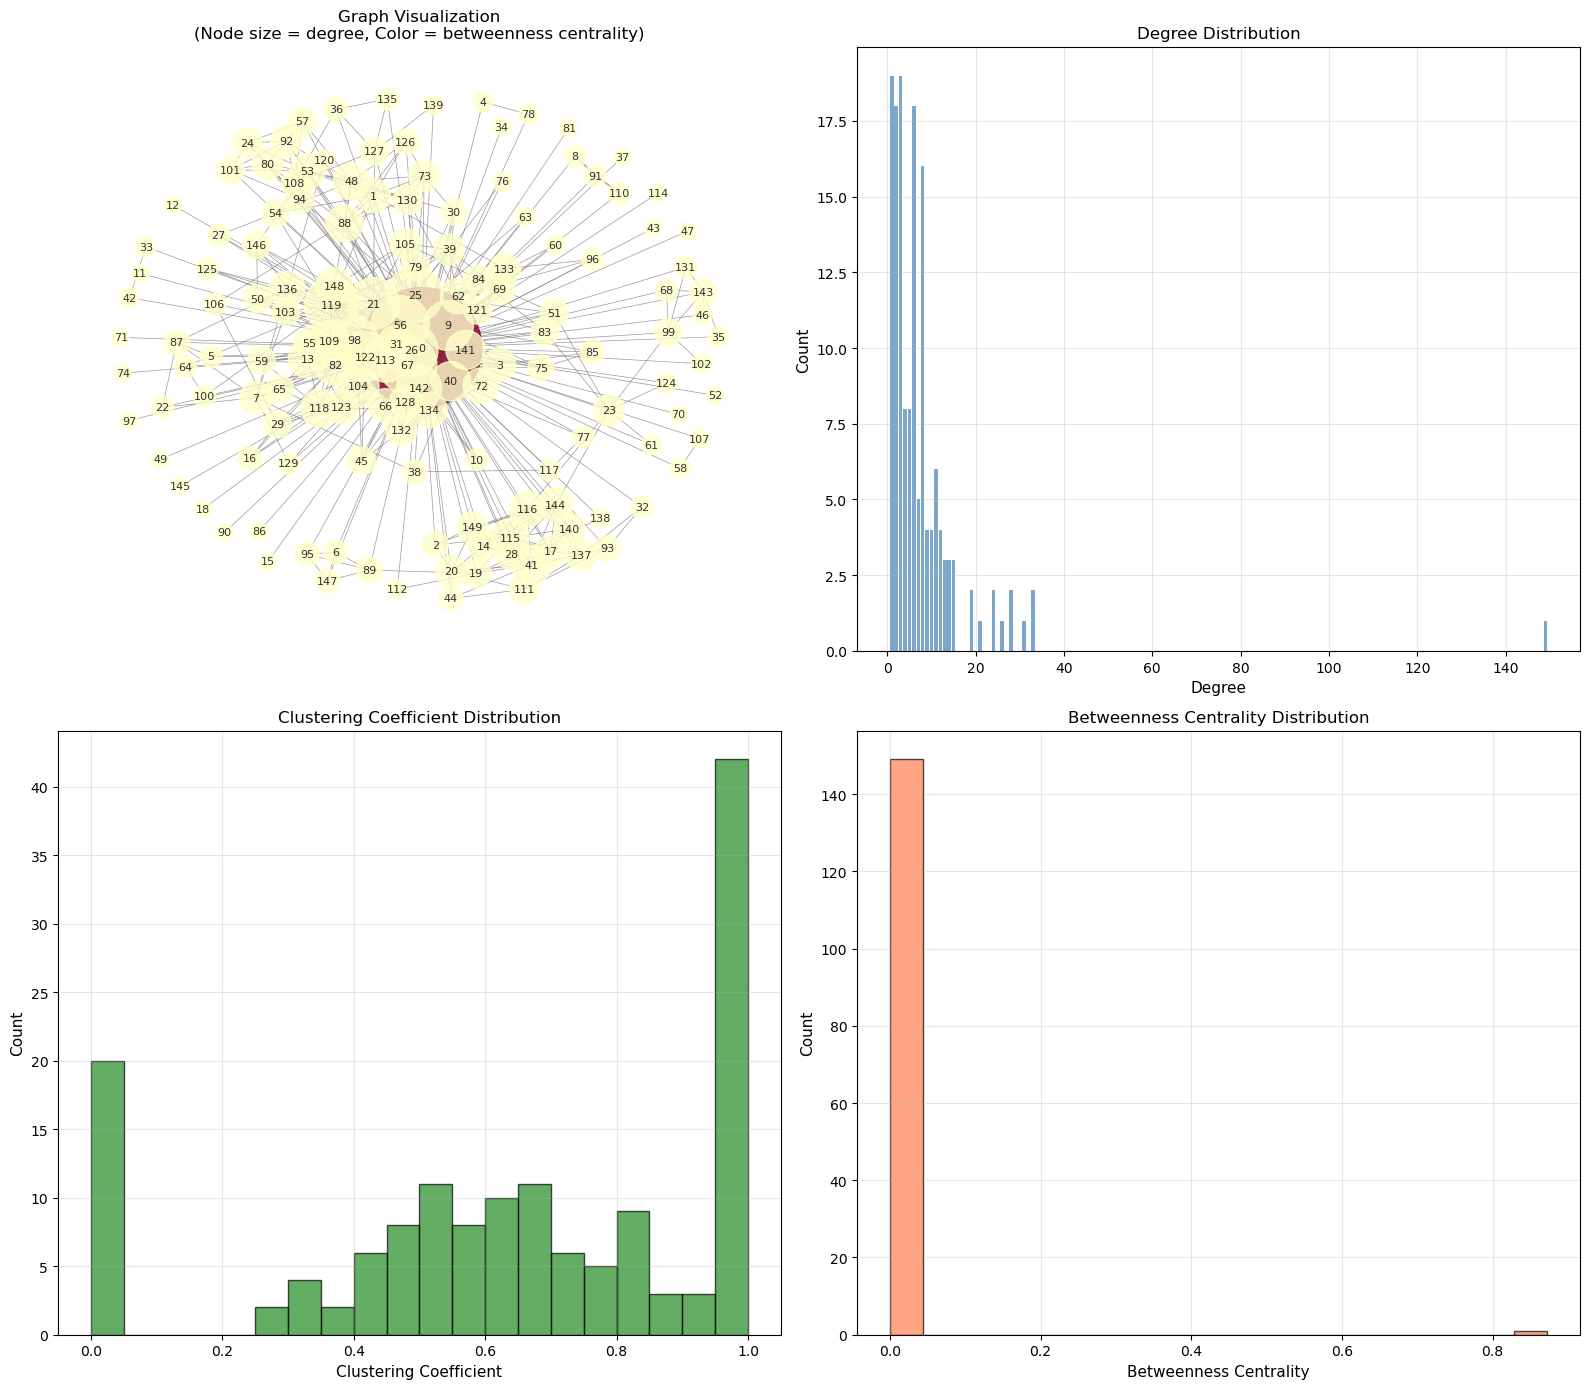

Visualization saved to: graph_visualization.png


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Main graph visualization
ax1 = axes[0, 0]
deg_dict = dict(G.degree())
node_sizes = [deg_dict[n] * 50 + 100 for n in G.nodes()]
node_colors = [betweenness[n] for n in G.nodes()]
pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50, seed=42)

nx.draw_networkx(G, pos, ax=ax1,
                 node_size=node_sizes,
                 node_color=node_colors,
                 cmap=plt.cm.YlOrRd,
                 with_labels=True,
                 font_size=8,
                 font_color='black',
                 edge_color='gray',
                 alpha=0.8,
                 width=0.5)
ax1.set_title('Graph Visualization\n(Node size = degree, Color = betweenness centrality)', fontsize=12)
ax1.axis('off')

# Plot 2: Degree distribution
ax2 = axes[0, 1]
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*sorted(degree_count.items()))
ax2.bar(deg, cnt, color='steelblue', alpha=0.7)
ax2.set_xlabel('Degree', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Degree Distribution', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Clustering coefficient distribution
ax3 = axes[1, 0]
clustering = nx.clustering(G)
ax3.hist(list(clustering.values()), bins=20, color='forestgreen', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Clustering Coefficient', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Clustering Coefficient Distribution', fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Betweenness centrality distribution
ax4 = axes[1, 1]
ax4.hist(list(betweenness.values()), bins=20, color='coral', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Betweenness Centrality', fontsize=11)
ax4.set_ylabel('Count', fontsize=11)
ax4.set_title('Betweenness Centrality Distribution', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graph_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("Visualization saved to: graph_visualization.png")

## Export for Gephi

Exporting in both CSV and GEXF formats so we can pull the graph into Gephi for more advanced visualization. The GEXF file includes node,level attributes (degree, clustering, betweenness) so they're immediately available for styling in Gephi without any extra processing.

In [5]:
# Export nodes CSV
deg_dict = dict(G.degree())
clustering = nx.clustering(G)

with open('nodes.csv', 'w') as f:
    f.write('Id,Label,Degree,Clustering,Betweenness\n')
    for node in G.nodes():
        f.write(f'{node},{node},{deg_dict[node]},{clustering[node]:.4f},{betweenness[node]:.4f}\n')

# Export edges CSV
with open('edges.csv', 'w') as f:
    f.write('Source,Target,Type\n')
    for edge in G.edges():
        f.write(f'{edge[0]},{edge[1]},Undirected\n')

# Export GEXF (native Gephi format)
for node in G.nodes():
    G.nodes[node]['degree'] = deg_dict[node]
    G.nodes[node]['clustering'] = round(clustering[node], 4)
    G.nodes[node]['betweenness'] = round(betweenness[node], 4)

nx.write_gexf(G, 'graph.gexf')

print("Exported: nodes.csv, edges.csv, graph.gexf")
print("\nGephi instructions:")
print("1. Open graph.gexf in Gephi")
print("2. Apply ForceAtlas2 layout")
print("3. Size nodes by degree, color by betweenness")
print("4. Export visualization for video presentation")

Exported: nodes.csv, edges.csv, graph.gexf

Gephi instructions:
1. Open graph.gexf in Gephi
2. Apply ForceAtlas2 layout
3. Size nodes by degree, color by betweenness
4. Export visualization for video presentation


## Part 4: Video Presentation

The ~5 minute video walkthrough covering this analysis, the key metrics, and the Gephi visualization is submitted separately.